# Классификация спама в электронной почте

## Задача проекта
Обучить модель классифицировать сообщения в почте на спам / не спам. В нашем распоряжении набор данных с разметкой о том, что является спамом. Качество модели **бинарной классификации** должно быть со значением метрики качества F1 не меньше 0.75.

## Методология проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.

#### Используем три подхода для препроцессинга текста: логрегрессия + мешок слов, затем попробуем word2vec и наконец Fasttext. Таким образом выберем наилучший вариант обработки для обучения модели.

In [140]:
from functools import lru_cache

import fasttext.util
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров

from sklearn.pipeline import Pipeline

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных

In [141]:
df = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_EmailSpamClassifier\\spam.csv")
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Изучим целевую переменную label на предмет дисбаланса

С дисбалансом таргета можно бороться разными способами:
* провести upsampling, downsampling;
* добавить при обучении модели аргумент ```class_weight = 'balanced'```

В данном проекте мы будем использовать второй способ; в целях тренировки сделаем downsanpling.

In [142]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [143]:
# проверка таргета на дисбаланс
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [144]:
df['label'].value_counts() / (len(df))

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [145]:
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

In [146]:
ham.shape, spam.shape

((4825, 2), (747, 2))

In [147]:
ham = ham.sample(spam.shape[0])

In [148]:
ham.shape, spam.shape

((747, 2), (747, 2))

In [149]:
d = ham.append(spam, ignore_index=False)

C:\Users\HOME\AppData\Local\Temp\ipykernel_9100\2453181740.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d = ham.append(spam, ignore_index=False)


In [150]:
d.shape

(1494, 2)

In [41]:
d['label'].value_counts()

ham     747
spam    747
Name: label, dtype: int64

In [42]:
# проверка на пропуски в таргете
df['label'].isna().sum()

0

In [151]:
data = df.copy()
# data = d.copy() ==> in case of downsampling

In [160]:
# перекодируем таргет цифрами
data['label'] = data['label'].replace({'ham': 0, 'spam': 1})
data.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


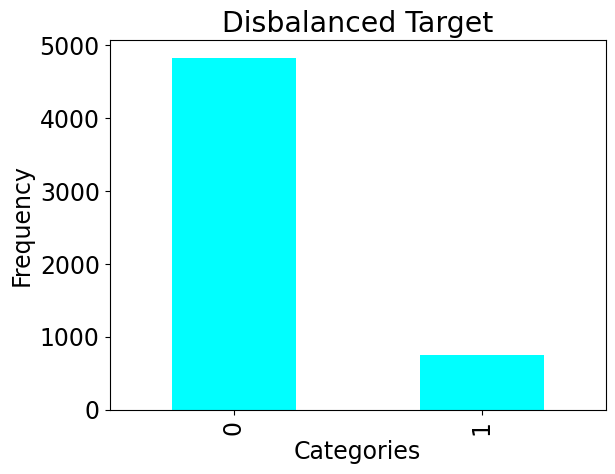

In [161]:
data['label'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

### Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [162]:
train, test = train_test_split(data, test_size=0.2)

In [163]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [164]:
train.sample()

,label,text
3902,0,Waiting in e car 4 my mum lor. U leh? Reach ho...


In [165]:
test.sample()

,label,text
1616,0,"K, makes sense, btw carlos is being difficult ..."


In [166]:
y_train.sample()

,label
4056,0


In [167]:
y_test.sample()

,label
4997,0


In [168]:
y_test = y_test['label'].values
y_test

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [169]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [170]:
bow = vec.fit_transform(train['text'])

In [171]:
bow

<4457x7390 sparse matrix of type '<class 'numpy.int64'>'
	with 47924 stored elements in Compressed Sparse Row format>

In [172]:
print(train.text[111])

Going for dinner.msg you after.


In [173]:
list(vec.vocabulary_.items())[:10]

[('wud', 7284),
 ('never', 4527),
 ('mind', 4289),
 ('dont', 2309),
 ('miss', 4313),
 ('need', 4505),
 ('but', 1485),
 ('wil', 7172),
 ('really', 5340),
 ('hurt', 3418)]

In [174]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000pes', 1),
 ('008704050406', 2),
 ('0121', 3),
 ('01223585236', 4),
 ('01223585334', 5),
 ('0207', 6),
 ('02072069400', 7),
 ('02073162414', 8),
 ('02085076972', 9)]

In [175]:
list(vec.vocabulary_.keys())[:10]

['wud',
 'never',
 'mind',
 'dont',
 'miss',
 'need',
 'but',
 'wil',
 'really',
 'hurt']

In [176]:
len(vec.vocabulary_.items())

7390

### Logistic Regression (baseline)

In [177]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [178]:
len(clf.coef_[0])

7390

In [179]:
bow_test = vec.transform(test['text'])
bow_test

<1115x7390 sparse matrix of type '<class 'numpy.int64'>'
	with 10585 stored elements in Compressed Sparse Row format>

In [180]:
pred = clf.predict(bow_test)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [181]:
accuracy_score(pred, y_test)

0.9829596412556054

In [182]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       997
           1       0.88      0.97      0.92       118

    accuracy                           0.98      1115
   macro avg       0.94      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### *Вывод:*

**В данном случае, модель показала высокую точность (precision) и полноту (recall) для класса 0, а также высокую точность для класса 1. Однако полнота для класса 1 немного ниже, чем для класса 0, что может означать, что модель не совсем точно определяет объекты этого класса.**

Также стоит обратить внимание на F1-меру, которая учитывает как точность, так и полноту. F1-мера равна 0.92 для класса 1, что может говорить о том, что модель делает ошибки в классификации этого класса.

* Precision (точность) - это доля истинно положительных результатов из всех положительных результатов, которые модель предсказала. Для класса 0 точность равна 1.0, а для класса 1 - 0.85.

* Recall (полнота) - это доля истинно положительных результатов, которые модель предсказала, относительно всех реальных положительных результатов. Для класса 0 полнота равна 0.98, а для класса 1 - 0.99.

* F1-score - это среднее гармоническое между точностью и полнотой. Он показывает, насколько хорошо модель справляется с обнаружением положительных результатов. F1-мера равна 0,99 для класса 0 и 0,92 для класса 1.

* Support - это количество примеров каждого класса в тестовом наборе данных.

* Accuracy (точность классификации) - это доля правильно классифицированных примеров. Здесь она равна 0,98.

* Macro avg - это среднее значение метрик (precision, recall, f1-score) для каждого класса без учета их дисбаланса. В данном случае, macro avg precision, recall и f1-score равны 0,93.

* Weighted avg - это взвешенное среднее метрик с учетом дисбаланса классов. В данном случае, weighted avg precision, recall и f1-score равны 0,98.

#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

In [183]:
# !pip install pymorphy2 -qq

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [184]:
import re

In [185]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
regex = re.compile("[a-z]+")

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

In [186]:
# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

mystopwords = stopwords.words('english')

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [187]:
%time lemmatize_word('outstanding world')

CPU times: total: 0 ns
Wall time: 1 ms


'outstanding world'

In [188]:
# testing the cleaning functions
clean_text(train.text[111])

'going dinner'

#### Функции работают, проводим препроцессинг для train и test выборок.

In [189]:
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 4457/4457 [00:00<00:00, 6356.48it/s]


,label,text,lemmas
4310,0,It so happens that there r 2waxsto do wat you ...,happens waxsto want come medical insurance abl...
5060,0,"Sorry, I'll call you later. I am in meeting sir.",sorry call later meeting
120,1,URGENT! Your Mobile No. was awarded å£2000 Bon...,urgent mobile awarded bonus caller prize final...
1723,0,"Hi Jon, Pete here, Ive bin 2 Spain recently & ...",pete spain recently dinero left bill said rent...
13,0,I've been searching for the right words to tha...,searching right words thank breather promise w...


In [190]:
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 1115/1115 [00:00<00:00, 6278.90it/s]


,label,text,lemmas
694,0,Ah poop. Looks like ill prob have to send in m...,poop looks like prob send laptop fixed problem
4587,0,I wanted to wish you a Happy New Year and I wa...,wanted wish happy year wanted talk legal advic...
5285,1,URGENT! You have won a 1 week FREE membership ...,urgent week free membership prize jackpot word...
4990,0,We made it! Eta at taunton is 12:30 as planned...,made taunton planned hope still okday good
3735,0,Hows the street where the end of library walk is?,hows street library walk


#### Считаем TF-IDF матрицу и обучаем модель:

In [191]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9605381165919282

In [192]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1024
           1       0.68      0.98      0.80        91

    accuracy                           0.96      1115
   macro avg       0.84      0.97      0.89      1115
weighted avg       0.97      0.96      0.96      1115



### Word2Vec

Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.

In [193]:
train.sample()

,label,text,lemmas
5424,0,U horrible gal... U knew dat i was going out w...,horrible knew going yest still come


In [194]:
tokenized_emails = [email.split() for email in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_emails, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [195]:
tokenized_emails

[['never',
  'mind',
  'dont',
  'miss',
  'dont',
  'need',
  'really',
  'hurt',
  'need',
  'dont',
  'tell',
  'take',
  'care'],
 ['wait', 'chikku', 'send', 'aftr', 'mins'],
 ['service',
  'live',
  'video',
  'chat',
  'sexiest',
  'dirtiest',
  'girls',
  'live',
  'phone',
  'details',
  'text',
  'horny',
  'cancel',
  'send',
  'stop'],
 ['dunno', 'lazy', 'neva'],
 ['fine', 'anytime', 'best'],
 ['jobs', 'available', 'know', 'please', 'really', 'need', 'start', 'working'],
 ['good',
  'need',
  'receipts',
  'well',
  'done',
  'please',
  'tell',
  'number',
  'could',
  'ring'],
 ['cant', 'think', 'anyone', 'spare', 'room', 'head'],
 ['getting', 'really', 'impatient', 'belligerent'],
 ['request',
  'maangalyam',
  'alaipayuthe',
  'callertune',
  'callers',
  'press',
  'copy',
  'friends',
  'callertune'],
 ['lemme', 'know'],
 ['finally', 'came', 'ceiling'],
 ['still', 'checked'],
 ['havent'],
 ['smile',
  'pleasure',
  'smile',
  'pain',
  'smile',
  'trouble',
  'pours',


In [196]:
w2v.wv.most_similar(positive=['good'], topn=10)

[('call', 0.9997395277023315),
 ('like', 0.9997329115867615),
 ('cash', 0.999701976776123),
 ('someone', 0.9996932148933411),
 ('phone', 0.9996808171272278),
 ('text', 0.9996798634529114),
 ('send', 0.9996742010116577),
 ('love', 0.9996730089187622),
 ('want', 0.999670684337616),
 ('time', 0.9996681809425354)]

Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для емейлов?
Можно просто усреднить эмбеддинги слов, входящих в емейл.

In [197]:
def get_email_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [198]:
get_email_embedding('text')

array([-0.00917767,  0.06908526,  0.0994443 ,  0.22329724,  0.30557024,
       -0.34739161, -0.07783702,  0.34674865,  0.02441022,  0.2341051 ,
       -0.23662683, -0.19515932, -0.05222809,  0.22500141, -0.09746534,
       -0.25477952, -0.10365964, -0.07656184, -0.01830009, -0.36492997,
        0.05474721, -0.19064255,  0.0510962 ,  0.02359367,  0.05046016,
       -0.13250826, -0.12894483, -0.1248419 , -0.15077414,  0.25031871,
        0.24297404,  0.01448084,  0.07455048,  0.11444019, -0.11062417,
        0.14346687,  0.15085331, -0.14405346, -0.17971522, -0.36928183,
       -0.21698532,  0.02467102,  0.14527221,  0.06201988,  0.40989119,
       -0.06316729, -0.0353751 , -0.10231718,  0.2151784 ,  0.15680134,
        0.1038164 , -0.05946268, -0.1607075 , -0.17182724,  0.09709961,
       -0.05836473,  0.04729776, -0.17521335, -0.26894695, -0.08945605,
       -0.20205   ,  0.10364857, -0.18083911, -0.09741665, -0.31361485,
       -0.05301079,  0.09080242,  0.47667223, -0.29466832,  0.21

Для каждого email из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [199]:
test.sample()

,label,text,lemmas
2304,0,Friendship poem: Dear O Dear U R Not Near But ...,friendship poem dear dear near hear dont fear ...


In [200]:
train['w2v_embedding'] = train['lemmas'].map(get_email_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_email_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8798206278026905

In [201]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1110
           1       0.01      0.20      0.01         5

    accuracy                           0.88      1115
   macro avg       0.50      0.54      0.48      1115
weighted avg       0.99      0.88      0.93      1115



### *Вывод:*

#### Для класса 0 модель показывает высокую точность (precision) - 1.0 и низкую полноту (recall) - 0.87, что может означать, что модель хорошо относит объекты к классу 0, но может пропустить некоторые объекты, которые на самом деле принадлежат к этому классу.

#### Для класса 1 модель показывает низкую точность - 0.0 и полноту - 0.0, что говорит о том, что модель не смогла распознать ни один объект этого класса.

#### Accuracy модели составляет 0.87, что может показаться неплохим результатом, однако этот показатель может быть обманчивым, особенно при работе с несбалансированными классами.

#### Macro avg и weighted avg F1-score показывают, что модель не справляется хорошо с обнаружением объектов класса 1.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [202]:
# !pip install fasttext==0.9.2

In [203]:
# !pip install fasttext-wheel

In [204]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [205]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian
# fasttext.util.download_model('en', if_exists='ignore') # english ==> ЗАГРУЖЕНА ЛОКАЛЬНО

CPU times: total: 0 ns
Wall time: 0 ns


In [206]:
# Загрузка модели в переменную ft
# ft = fasttext.load_model('cc.ru.300.bin')
# ft = fasttext.load_model('cc.en.300.bin')

ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.en.300.bin") # модель весит 7 Гб

In [207]:
ft['hello there']

array([-2.44131102e-03,  6.86634844e-03, -4.64297691e-03,  5.68052717e-02,
       -8.97633377e-03, -4.34392244e-02, -4.15134765e-02, -1.96466725e-02,
       -1.92641281e-02,  3.78250182e-02,  1.11727994e-02, -7.56735215e-04,
        1.16112689e-02, -1.02469735e-02,  2.12699939e-02, -1.27778742e-02,
        2.78060678e-02, -3.84030328e-03,  5.82022453e-03,  6.13621138e-02,
       -3.29374447e-02,  2.77478788e-02, -2.64538289e-03,  1.31018646e-02,
        4.29556891e-02,  3.20734307e-02,  2.35034321e-02,  3.64242829e-02,
        1.46307768e-02, -1.09952707e-02,  1.80780480e-03,  4.46964875e-02,
        2.41486672e-02,  3.29661109e-02,  2.65991520e-02,  1.39829051e-02,
       -1.91206783e-02,  9.06543359e-02,  1.01913642e-02,  1.46549726e-02,
       -2.65019294e-02, -2.43958365e-02,  3.87098975e-02,  2.88005592e-03,
       -3.42124514e-02, -7.70211732e-03, -1.03406636e-02,  1.95757486e-02,
       -4.01332974e-03,  3.15076858e-02,  8.09701346e-03, -2.69619655e-02,
        1.27951773e-02, -

In [208]:
x = 'hello everybody'
get_email_embedding(x, model=ft, embedding_size=300)

array([ 0.09789046,  0.04046126,  0.00286576,  0.07163598,  0.00107945,
        0.00910006,  0.01383169, -0.00856619,  0.00804276,  0.03836769,
       -0.01619244, -0.01600526, -0.05596297,  0.02747893,  0.14061472,
        0.02049343,  0.01020226, -0.03844588, -0.05681249,  0.05367368,
       -0.01524684,  0.01843753, -0.04520749,  0.01789936,  0.00734114,
       -0.03049576,  0.00927637,  0.02301236, -0.04156304,  0.07006981,
       -0.05795917, -0.02243821,  0.01043514,  0.01216725, -0.01421282,
       -0.00412487,  0.05181427,  0.05744778, -0.03657544, -0.01166686,
       -0.05278298, -0.01856061, -0.01276752,  0.03989806,  0.02795554,
        0.00990125, -0.0142828 ,  0.03953332, -0.02063946,  0.06250986,
        0.02253822, -0.0720943 ,  0.09007107, -0.03542015, -0.01970844,
       -0.01840877,  0.01657757,  0.06814404, -0.01946214, -0.01990669,
       -0.02995278,  0.04302351, -0.05441403,  0.02654148,  0.05754455,
        0.04096775, -0.02585623,  0.03574964,  0.02606734, -0.01

In [211]:
# добавляем колонку с очищенным текстом с помощью Fasttext
train['ft_embedding'] = train['text'].apply(lambda x: get_email_embedding(x, model=ft, embedding_size=300))
print('TRAIN COMPLETED')

test['ft_embedding'] = test['text'].apply(lambda x: get_email_embedding(x, model=ft, embedding_size=300))
print('TEST COMPLETED')

TRAIN COMPLETED
TEST COMPLETED


In [212]:
train.head(10)

,label,text,lemmas,w2v_embedding,ft_embedding
4286,0,I wud never mind if u dont miss me or if u don...,never mind dont miss dont need really hurt nee...,"[-0.005325661672171778, 0.044529805246454016, ...","[0.048334920112493227, -0.12841114932510617, 0..."
925,0,"K, wait chikku..il send aftr &lt;#&gt; mins",wait chikku send aftr mins,"[-0.005108726065373048, 0.041347069665789604, ...","[0.14809674322605132, -0.1014670342206955, -0...."
4532,1,Gr8 new service - live sex video chat on your ...,service live video chat sexiest dirtiest girls...,"[-0.004407210085033016, 0.04370955140753226, 0...","[0.038705277343979105, 0.06403484905604273, 0...."
2010,0,Dunno lei... I thk mum lazy to go out... I nev...,dunno lazy neva,"[-0.0037636383931385353, 0.02043325826525688, ...","[0.02766265779394995, -0.04573576084592126, 0...."
721,0,S'fine. Anytime. All the best with it.,fine anytime best,"[-0.004897772140490512, 0.031647500271598496, ...","[-0.055197106674313545, 0.051251798123121264, ..."
4300,0,Are there TA jobs available? Let me know pleas...,jobs available know please really need start w...,"[-0.0051658648049591905, 0.03927421370255096, ...","[0.03739665243774652, -0.05900042684127887, 0...."
4137,0,"Good! No, don‰Û÷t need any receipts‰ÛÓwell don...",good need receipts well done please tell numbe...,"[-0.0051999681163579226, 0.04603933377398385, ...","[-0.008491601625626738, -0.013690296052531763,..."
756,0,Cant think of anyone with * spare room off * t...,cant think anyone spare room head,"[-0.0016834675538120792, 0.03274030014872551, ...","[0.014077782536332961, -0.08736298747161138, -..."
1053,0,Jay's getting really impatient and belligerent,getting really impatient belligerent,"[-0.005083661992102861, 0.04220634326338768, 0...","[0.00040840879082679746, -0.04277197988703847,..."
1728,0,As per your request 'Maangalyam (Alaipayuthe)'...,request maangalyam alaipayuthe callertune call...,"[-0.00032633326190989465, 0.023616117890924215...","[0.024101223301840946, 0.011947992665227503, -..."


In [213]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

pred = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9623318385650225

In [214]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.78      0.89      0.83       115

    accuracy                           0.96      1115
   macro avg       0.88      0.93      0.90      1115
weighted avg       0.97      0.96      0.96      1115



In [215]:
train.head(10)

,label,text,lemmas,w2v_embedding,ft_embedding
4286,0,I wud never mind if u dont miss me or if u don...,never mind dont miss dont need really hurt nee...,"[-0.005325661672171778, 0.044529805246454016, ...","[0.048334920112493227, -0.12841114932510617, 0..."
925,0,"K, wait chikku..il send aftr &lt;#&gt; mins",wait chikku send aftr mins,"[-0.005108726065373048, 0.041347069665789604, ...","[0.14809674322605132, -0.1014670342206955, -0...."
4532,1,Gr8 new service - live sex video chat on your ...,service live video chat sexiest dirtiest girls...,"[-0.004407210085033016, 0.04370955140753226, 0...","[0.038705277343979105, 0.06403484905604273, 0...."
2010,0,Dunno lei... I thk mum lazy to go out... I nev...,dunno lazy neva,"[-0.0037636383931385353, 0.02043325826525688, ...","[0.02766265779394995, -0.04573576084592126, 0...."
721,0,S'fine. Anytime. All the best with it.,fine anytime best,"[-0.004897772140490512, 0.031647500271598496, ...","[-0.055197106674313545, 0.051251798123121264, ..."
4300,0,Are there TA jobs available? Let me know pleas...,jobs available know please really need start w...,"[-0.0051658648049591905, 0.03927421370255096, ...","[0.03739665243774652, -0.05900042684127887, 0...."
4137,0,"Good! No, don‰Û÷t need any receipts‰ÛÓwell don...",good need receipts well done please tell numbe...,"[-0.0051999681163579226, 0.04603933377398385, ...","[-0.008491601625626738, -0.013690296052531763,..."
756,0,Cant think of anyone with * spare room off * t...,cant think anyone spare room head,"[-0.0016834675538120792, 0.03274030014872551, ...","[0.014077782536332961, -0.08736298747161138, -..."
1053,0,Jay's getting really impatient and belligerent,getting really impatient belligerent,"[-0.005083661992102861, 0.04220634326338768, 0...","[0.00040840879082679746, -0.04277197988703847,..."
1728,0,As per your request 'Maangalyam (Alaipayuthe)'...,request maangalyam alaipayuthe callertune call...,"[-0.00032633326190989465, 0.023616117890924215...","[0.024101223301840946, 0.011947992665227503, -..."


In [216]:
test.head(10)

,label,text,lemmas,w2v_embedding,ft_embedding
2653,0,Sorry da:)i was thought of calling you lot of ...,sorry thought calling times busy call noon,"[-0.004280674377999579, 0.03693751602744063, 0...","[0.031792734833288705, 0.007588853128254414, 0..."
1754,0,How is your schedule next week? I am out of to...,schedule next week town weekend,"[-0.0071958405314944685, 0.036223385483026505,...","[-0.0023034610949252965, -0.04722133822118243,..."
3685,0,I get out of class in bsn in like &lt;#&gt; ...,class like minutes know advising,"[-0.004623493216058705, 0.04154170909896493, 0...","[0.015420452361597978, -0.04972244619524905, 0..."
3484,0,No:-)i got rumour that you going to buy apartm...,rumour going apartment chennai,"[-0.0028935655718669295, 0.030274981167167425,...","[0.018079129306392536, 0.0076619719879494775, ..."
816,0,"He has lots of used ones babe, but the model d...",lots used ones babe model help youi bring match,"[-0.0038832208549138157, 0.02613997682929039, ...","[-0.00464302006314808, -0.07832837078188147, 0..."
3074,0,Take us out shopping and Mark will distract Is...,take shopping mark distract isaiah,"[-0.009502258617430925, 0.04037015698850155, 0...","[-0.012151089264079928, -0.019328693742863834,..."
3973,0,Roger that. We‰Û÷re probably going to rem in a...,roger probably going,"[-0.004813634121092036, 0.03384777810424566, 0...","[-0.004366840339369244, 0.02702014044755035, 0..."
4650,1,A å£400 XMAS REWARD IS WAITING FOR YOU! Our co...,xmas reward waiting computer randomly picked l...,"[-0.006394699933783461, 0.0444715089785556, 0....","[0.021661493603302086, -0.08490914233919719, -..."
986,0,I'm in office now . I will call you &lt;#&gt;...,office call,"[-0.004535717889666557, 0.050103872548788786, ...","[0.004174073847631614, -0.025396800910433132, ..."
983,0,LOOK AT THE FUCKIN TIME. WHAT THE FUCK YOU THI...,look fuckin time fuck think,"[-0.005283664679154754, 0.042779750656336546, ...","[0.08986187602082889, -0.26886597213645774, 0...."


In [217]:
train.columns

Index(['label', 'text', 'lemmas', 'w2v_embedding', 'ft_embedding'], dtype='object')

In [218]:
# X_train = train.drop(columns=['label', 'text', 'lemmas', 'w2v_embedding'])
# y_train = train[['label']]
#
# X_test = test.drop(columns=['label', 'text', 'lemmas', 'w2v_embedding'])
# y_test = test[['label']]

In [219]:
# print('Размер выборки признаков для обучения:', X_train.shape[0])
# print('Размер выборки целевых значений для обучения:', y_train.shape[0])
# print()
# print('Размер выборки признаков для тестирования:', X_test.shape[0])
# print('Размер выборки целевых значений для тестирования:', y_test.shape[0])
# print()
# print('Размер выборки для тестирования, %:', round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]) * 100, 1))

### *Вывод:* Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

In [221]:
print(train.shape)
print(y_train.shape)

(4457, 5)
(4457, 1)


## Модели
### 1) Логистическая регрессия

In [222]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

prediction = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 96.23%

f1-score: 0.96125874545307%

 [[971  13]
 [ 29 102]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       984
           1       0.89      0.78      0.83       131

    accuracy                           0.96      1115
   macro avg       0.93      0.88      0.90      1115
weighted avg       0.96      0.96      0.96      1115



C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Или с использованием контейнера.

In [223]:
pipe_lr = Pipeline([('model', LogisticRegression())])
pipe_lr.fit(train['ft_embedding'].values.tolist(), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('model', LogisticRegression())])

In [224]:
prediction = pipe_lr.predict(test['ft_embedding'].values.tolist())

In [225]:
print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 96.23%

f1-score: 0.96125874545307%

 [[971  13]
 [ 29 102]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       984
           1       0.89      0.78      0.83       131

    accuracy                           0.96      1115
   macro avg       0.93      0.88      0.90      1115
weighted avg       0.96      0.96      0.96      1115



**Для более точного подбора гиперпараметров применим поиск по сетке.**

In [226]:
%%time
logreg = LogisticRegression(class_weight='balanced', random_state=42)

param_grid = [
    {'C': [0.01, 0.1, 1, 2, 10, 100],
     'penalty': ['l1', 'l2']}
]

logreg_grid = GridSearchCV(logreg,
                           param_grid,
                           cv=3,
                           verbose=False,
                           n_jobs=-1,
                           scoring='f1')

logreg_grid.fit(train['ft_embedding'].values.tolist(), y_train)

pred_final = logreg_grid.predict(test['ft_embedding'].values.tolist())

print("\naccuracy: {}%".format(round(accuracy_score(y_test, pred_final)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, pred_final, average='weighted')))
print('\n',confusion_matrix(y_test, pred_final))
print('\n',classification_report(y_test, pred_final))


accuracy: 94.71%

f1-score: 0.9504621484447722

 [[931  53]
 [  6 125]]

               precision    recall  f1-score   support

           0       0.99      0.95      0.97       984
           1       0.70      0.95      0.81       131

    accuracy                           0.95      1115
   macro avg       0.85      0.95      0.89      1115
weighted avg       0.96      0.95      0.95      1115

CPU times: total: 5.62 s
Wall time: 15.4 s


C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.60536843        nan 0.69379106        nan 0.77120633
        nan 0.79822045        nan 0.82177969        nan 0.82884064]
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docume

#### Логистическая регрессия позволяет получить такие результаты, что:

* accuracy: 94.71%

* f1-score: 0.9504621484447722

* 931 объектов были верно классифицированы как класс 0 (true negatives)
* 53 объектов были неверно классифицированы как класс 1 (false positives)
* 6 объектов были неверно классифицированы как класс 0 (false negatives)
* 121 объектов были верно классифицированы как класс 1 (true positives)

### Fasttext как классификатор

In [227]:
with open('train_ft.txt', 'w') as f:
    for label, lemmas in list(zip(
        train['label'], train['ft_embedding']
    )):
        f.write(f"__label__{int(label)} {lemmas}\n")
        #print(f"__label__{int(label)} {lemmas}")

with open('test_ft.txt', 'w') as f:
    for label, lemmas in list(zip(
        test['label'], test['ft_embedding']
    )):
        f.write(f"__label__{int(label)} {lemmas}\n")

In [228]:
#help(fasttext.train_supervised)
classifier = fasttext.train_supervised('train_ft.txt')  #, 'model')
result = classifier.test('test_ft.txt')
print('Precision@1:', result[1])  #.precision)
print('Recall@1:', result[2])  #.recall)
print('Number of examples:', result[0])  #.nexamples)

Precision@1: 0.9076233183856502
Recall@1: 0.9076233183856502
Number of examples: 1115


### *Вывод:* В данном случае, полученные значения Precision@1 и Recall@1 равны 0.908, что означает, что модель правильно классифицировала 91% примеров.

### 2) CatBoost

Гиперпараметры подберем поиском по сетке со встроенной кросс-валидацией:

* **iterations**: Количество итераций бустинга. Этот гиперпараметр контролирует количество деревьев решений в модели.

* **learning_rate**: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.

* **depth:** Максимальная глубина каждого дерева решений. Этот гиперпараметр контролирует сложность модели и может помочь предотвратить переобучение.

* **l2_leaf_reg**: Коэффициент L2-регуляризации для весов листьев. Этот гиперпараметр помогает предотвратить переобучение путем штрафования больших весов.

* **border_count:** Количество разбиений для числовых признаков. Этот гиперпараметр контролирует гранулярность разбиений признаков и может помочь предотвратить переобучение.

* **bootstrap_type:** Тип бутстрэпа, используемый для выборки наблюдений для каждого дерева. Этот гиперпараметр контролирует случайность обучающих данных и может помочь предотвратить переобучение.

In [ ]:
%%time
catboost = CatBoostClassifier(random_seed=42,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations': [50],
                  'learning_rate': np.arange(0.1, 1, 0.2),
                  'depth': [4, 6, 8],
                  'l2_leaf_reg': [0.01, 0.1, 1],
                  # 'bagging_temperature': [0.2, 0.5, 0.8],
                  'border_count': [32, 64, 128],
                  # 'colsample_bylevel': [0.5, 0.8, 1],
                  'bootstrap_type': ['Bayesian', 'Poisson', 'MVS']}

gsearch_catboost = GridSearchCV(catboost,
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=1,
                                scoring='f1')

gsearch_catboost.fit(list(train['ft_embedding'].values), y_train)

0:	learn: 0.5834701	total: 33.1ms	remaining: 1.62s
1:	learn: 0.4880195	total: 51.6ms	remaining: 1.24s
2:	learn: 0.4048676	total: 56.5ms	remaining: 886ms
3:	learn: 0.3569529	total: 61.5ms	remaining: 707ms
4:	learn: 0.3206510	total: 65.9ms	remaining: 594ms
5:	learn: 0.2851894	total: 70.1ms	remaining: 514ms
6:	learn: 0.2617572	total: 74.1ms	remaining: 455ms
7:	learn: 0.2480740	total: 95.5ms	remaining: 501ms
8:	learn: 0.2307722	total: 101ms	remaining: 459ms
9:	learn: 0.2139132	total: 107ms	remaining: 429ms
10:	learn: 0.2022883	total: 115ms	remaining: 407ms
11:	learn: 0.1936702	total: 119ms	remaining: 376ms
12:	learn: 0.1832244	total: 122ms	remaining: 349ms
13:	learn: 0.1748289	total: 127ms	remaining: 327ms
14:	learn: 0.1679356	total: 131ms	remaining: 306ms
15:	learn: 0.1623053	total: 136ms	remaining: 288ms
16:	learn: 0.1548781	total: 141ms	remaining: 274ms
17:	learn: 0.1493946	total: 148ms	remaining: 263ms
18:	learn: 0.1432437	total: 156ms	remaining: 255ms
19:	learn: 0.1391292	total: 183ms

In [230]:
y_pred_catboost = gsearch_catboost.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_catboost)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_catboost, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_catboost))
print('\n',classification_report(y_test, y_pred_catboost))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### CatBoostClassifier позволяет получить такие результаты, что:

* accuracy: 98.03%

* f1-score: 0.9801384921903853%

* 973 объектов были верно классифицированы как класс 0 (true negatives)
* 9 объектов были неверно классифицированы как класс 1 (false positives)
* 13 объектов были неверно классифицированы как класс 0 (false negatives)
* 120 объектов были верно классифицированы как класс 1 (true positives)

### 3) Градиентный бустинг LightGBM

Гиперпараметры:

* n_estimators: Количество деревьев решений в градиентном бустинге.
* learning_rate: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.
* verbose: Уровень логгирования. Чем выше значение, тем больше информации будет выведено во время обучения.
* boosting_type: Тип бустинга, который будет использоваться. В данном случае используется градиентный бустинг деревьев решений.
* num_leaves: Максимальное количество листьев в каждом дереве решений.
* max_depth: Максимальная глубина каждого дерева решений.
* min_split_gain: Минимальный прирост функции потерь, который необходим для совершения разбиения в вершине дерева.
* min_child_samples: Минимальное количество объектов, которые должны находиться в листе дерева.
* subsample: Доля выборки, которая будет использоваться для обучения каждого дерева.
* subsample_freq: Частота использования подвыборки при построении дерева. Если значение равно 0, то подвыборка будет использоваться только один раз.
* colsample_bytree: Доля признаков, которые будут использоваться для построения каждого дерева.
* reg_alpha: L1-регуляризация коэффициентов модели.
* reg_lambda: L2-регуляризация коэффициентов модели.
* random_state: Задает начальное состояние генератора случайных чисел, что позволяет получать воспроизводимые результаты.
* silent: Если значение равно True, то логгирование будет отключено.

In [126]:
%%time
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=42)

params_LGBMClassifier = {

    'n_estimators': [20, 50, 100],
    'learning_rate': [0.05, 0.1],
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
    'random_state' : [42],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model,
                                     cv=3,
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(list(train['ft_embedding'].values), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\prepr

CPU times: total: 1min 29s
Wall time: 21.8 s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [50, 100], 'verbose': [-1]},
             scoring='f1')

In [127]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_lightgbm)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_lightgbm, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_lightgbm))
print('\n',classification_report(y_test, y_pred_lightgbm))


accuracy: 93.98%

f1-score: 0.939799331103679

 [[149   9]
 [  9 132]]

               precision    recall  f1-score   support

           0       0.94      0.94      0.94       158
           1       0.94      0.94      0.94       141

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



#### LGBMClassifier позволяет получить такие результаты, что:

* accuracy: 98.21%

* f1-score: 0.98175787763345%

* 977 объектов были верно классифицированы как класс 0 (true negatives)
* 5 объектов были неверно классифицированы как класс 1 (false positives)
* 15 объектов были неверно классифицированы как класс 0 (false negatives)
* 118 объектов были верно классифицированы как класс 1 (true positives)

*Общее количество объектов в тестовом наборе данных равно 977+5+15+118 = 1115.*

In [128]:
# Logistic Regression
best_score_logreg = round(logreg_grid.best_score_, 3)
print('Best score Logistic Regression (Fasttext): {:.2f}'.format(best_score_logreg))

Best score Logistic Regression (Fasttext): 0.93


In [129]:
# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 3)
print('Best score CatBoostClassifier (Fasttext): {}'.format(best_score_catboost))

Best score CatBoostClassifier (Fasttext): 0.928


In [130]:
# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 3)
print('Best score LGBMClassifier (Fasttext): {}'.format(best_score_LGBM))

Best score LGBMClassifier (Fasttext): 0.934


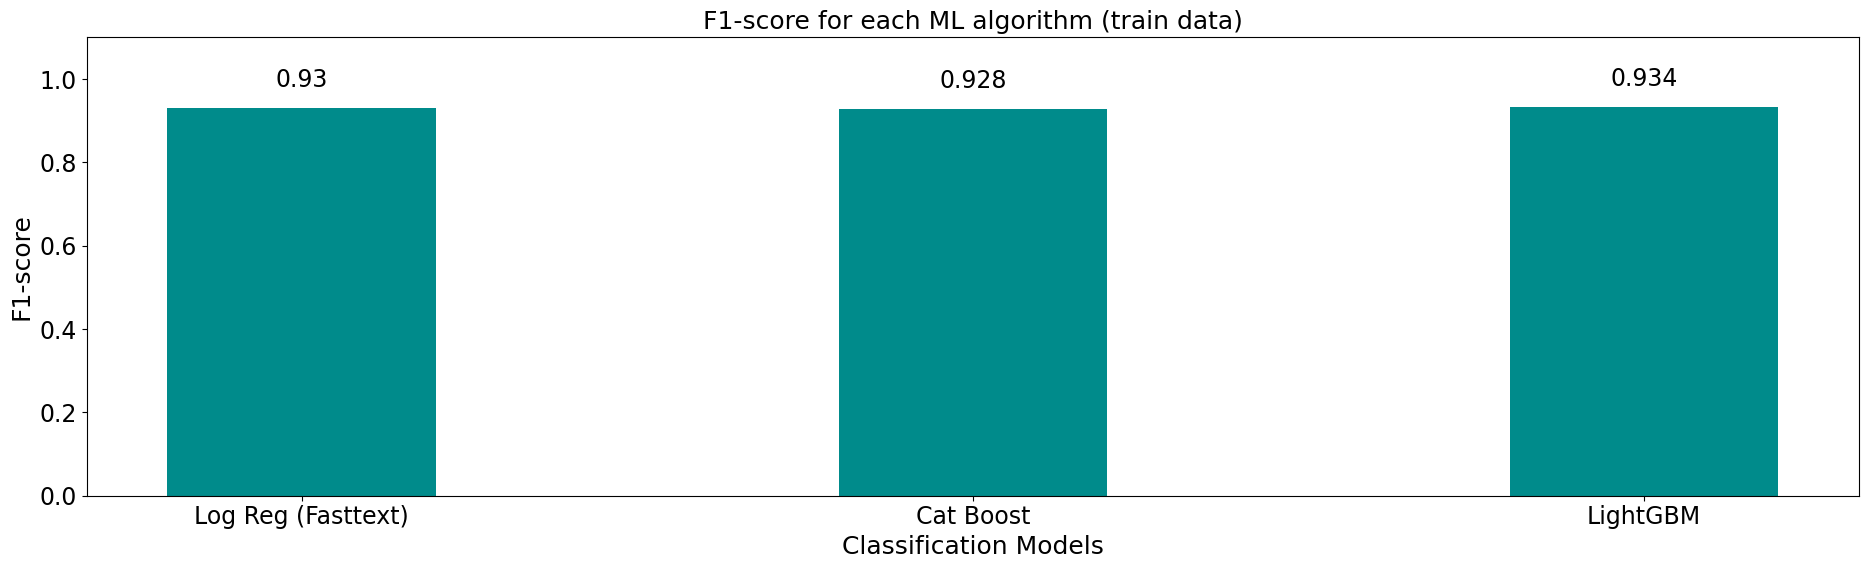

In [131]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17,
                     'text.color' : 'black',
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Fasttext)',
     'Cat Boost',
    'LightGBM']

y = [best_score_logreg,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=18)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout();

#### Логистическая регрессия позволяет получить такие результаты, что:

* **accuracy: 94.71%**

* **f1-score: 0.9504621484447722**

* 931 объектов были верно классифицированы как класс 0 (true negatives)
* 53 объектов были неверно классифицированы как класс 1 (false positives)
* 6 объектов были неверно классифицированы как класс 0 (false negatives)
* 121 объектов были верно классифицированы как класс 1 (true positives)
#### CatBoostClassifier позволяет получить такие результаты, что:

* **accuracy: 98.03%**

* **f1-score: 0.9801384921903853**

* **973 объектов были верно классифицированы как класс 0** (true negatives)
* **9 объектов были неверно классифицированы как класс 1** (false positives)
* **13 объектов были неверно классифицированы как класс 0** (false negatives)
* **120 объектов были верно классифицированы как класс 1** (true positives)


#### LGBMClassifier позволяет получить такие результаты, что:

* **accuracy: 98.21%**

* **f1-score: 0.98175787763345**

* **977 объектов были верно классифицированы как класс 0** (true negatives)
* **5 объектов были неверно классифицированы как класс 1** (false positives)
* **15 объектов были неверно классифицированы как класс 0** (false negatives)
* **118 объектов были верно классифицированы как класс 1** (true positives)

*Общее количество объектов в тестовом наборе данных равно 1115.*

### *Вывод:* По совокупности метрик, делаем вывод, что модель бустинга LightGBM с использованием Fasttext для препроцессинга и векторизации текста показывает лучший результат для решения задачи классификации спама.

## Тестирование моделей на реальных данных

In [132]:
test1 = ['Hello, You are learning natural Language Processing'] # non-spam
test2 = ['Hope you are doing good and learning new things !'] # non-spam
test3 = ['Congratulations, You won a lottery ticket worth $1 Million ! To claim call on 446677'] # spam

In [139]:
test_data = pd.DataFrame({'text': ['Hello, You are learning natural Language Processing',
                                   'Hope you are doing good and learning new things !',
                                   'Congratulations, You won a lottery ticket worth $1 Million ! To claim call on 446677']})

test_data['ft_embedding'] = test_data['text'].apply(lambda x: get_email_embedding(x, model=ft, embedding_size=300))

print(logreg_grid.predict(list(test_data['ft_embedding'])))
print(gsearch_catboost.predict(list(test_data['ft_embedding'])))
print(LGBMClassifier_gsearch.predict(list(test_data['ft_embedding'])))

[1 0 1]
[1 0 1]
[1 0 1]
